## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [10]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [16]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.9,0.8,0.5,0.4]
redice_lr_patient = [3,5,8,10]

In [17]:
import itertools
from keras.callbacks import ReduceLROnPlateau
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 3
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________________________________

49/49 [==============================] - 4s 84ms/step - loss: 1.3459 - accuracy: 0.5334 - val_loss: 1.5103 - val_accuracy: 0.4707
Epoch 11/25
49/49 [==============================] - 4s 88ms/step - loss: 1.3184 - accuracy: 0.5420 - val_loss: 1.5043 - val_accuracy: 0.4706
Epoch 12/25
49/49 [==============================] - 4s 79ms/step - loss: 1.2923 - accuracy: 0.5533 - val_loss: 1.4969 - val_accuracy: 0.4710
Epoch 13/25
49/49 [==============================] - 4s 78ms/step - loss: 1.2684 - accuracy: 0.5608 - val_loss: 1.4858 - val_accuracy: 0.4795
Epoch 14/25
49/49 [==============================] - 4s 79ms/step - loss: 1.2467 - accuracy: 0.5695 - val_loss: 1.4885 - val_accuracy: 0.4742
Epoch 15/25
49/49 [==============================] - 4s 83ms/step - loss: 1.2237 - accuracy: 0.5777 - val_loss: 1.4773 - val_accuracy: 0.4801
Epoch 16/25
49/49 [==============================] - 4s 79ms/step - loss: 1.2021 - accuracy: 0.5863 - val_loss: 1.4702 - val_accuracy: 0.4802
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 4s 91ms/step - loss: 2.2450 - accuracy: 0.2660 - val_loss: 2.1477 - val_accuracy: 0.2012
Epoch 2/25
49/49 [==============================] - 4s 79ms/step - loss: 1.7705 - accuracy: 0.3841 - val_loss: 1.9947 - val_accuracy: 0.2722
Epoch 3/25
49/49 [==============================] - 4s 81ms/step - loss: 1.6460 - accuracy: 0.4261 - val_loss: 1.8702 - val_accuracy: 0.3393
Epoch 4/25
49/49 [==============================] - 4s 80ms/step - loss: 1.5745 - accuracy: 0.4509 - val_loss: 1.7572 - val_accuracy: 0.3843
Epoch 5/25
49/49 [==============================] - 4s 81ms/step - loss: 1.5198 - accuracy: 0.4687 - val_loss: 1.6975 - val_accuracy: 0.4007
Epoch 6/25
49/49 [==============================] - 4s 80ms/step - loss: 1.4771 - accuracy: 0.4856 - val_loss: 1.6201 - val_accuracy: 0.4308
Epoch 7/25
49/49 [==============================] - 4s 85ms/step - loss: 1.4388 - accuracy: 0.4980 - val_loss: 1.5847 - val_accuracy: 0.4393
Epoch 8/25
49

49/49 [==============================] - 4s 78ms/step - loss: 1.0762 - accuracy: 0.6337 - val_loss: 1.4588 - val_accuracy: 0.4931
Epoch 24/25
49/49 [==============================] - 4s 77ms/step - loss: 1.0583 - accuracy: 0.6426 - val_loss: 1.4617 - val_accuracy: 0.4925
Epoch 25/25
49/49 [==============================] - 4s 79ms/step - loss: 1.0400 - accuracy: 0.6479 - val_loss: 1.4602 - val_accuracy: 0.4936
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 5
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
___________________________________________

49/49 [==============================] - 4s 87ms/step - loss: 1.3465 - accuracy: 0.5330 - val_loss: 1.5120 - val_accuracy: 0.4679
Epoch 11/25
49/49 [==============================] - 4s 91ms/step - loss: 1.3199 - accuracy: 0.5418 - val_loss: 1.4973 - val_accuracy: 0.4698
Epoch 12/25
49/49 [==============================] - 4s 91ms/step - loss: 1.2965 - accuracy: 0.5519 - val_loss: 1.4905 - val_accuracy: 0.4792
Epoch 13/25
49/49 [==============================] - 4s 81ms/step - loss: 1.2725 - accuracy: 0.5595 - val_loss: 1.4808 - val_accuracy: 0.4797
Epoch 14/25
49/49 [==============================] - 4s 83ms/step - loss: 1.2487 - accuracy: 0.5699 - val_loss: 1.4924 - val_accuracy: 0.4736
Epoch 15/25
49/49 [==============================] - 4s 83ms/step - loss: 1.2277 - accuracy: 0.5760 - val_loss: 1.4708 - val_accuracy: 0.4861
Epoch 16/25
49/49 [==============================] - 4s 82ms/step - loss: 1.2060 - accuracy: 0.5859 - val_loss: 1.4726 - val_accuracy: 0.4884
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 5s 94ms/step - loss: 2.2695 - accuracy: 0.2559 - val_loss: 2.1485 - val_accuracy: 0.2055
Epoch 2/25
49/49 [==============================] - 4s 88ms/step - loss: 1.7691 - accuracy: 0.3840 - val_loss: 1.9844 - val_accuracy: 0.2934
Epoch 3/25
49/49 [==============================] - 4s 82ms/step - loss: 1.6428 - accuracy: 0.4254 - val_loss: 1.8485 - val_accuracy: 0.3551
Epoch 4/25
49/49 [==============================] - 4s 84ms/step - loss: 1.5691 - accuracy: 0.4498 - val_loss: 1.7491 - val_accuracy: 0.3903
Epoch 5/25
49/49 [==============================] - 4s 92ms/step - loss: 1.5148 - accuracy: 0.4713 - val_loss: 1.6651 - val_accuracy: 0.4180
Epoch 6/25
49/49 [==============================] - 4s 88ms/step - loss: 1.4694 - accuracy: 0.4869 - val_loss: 1.6053 - val_accuracy: 0.4335
Epoch 7/25
49/49 [==============================] - 4s 82ms/step - loss: 1.4326 - accuracy: 0.4996 - val_loss: 1.5740 - val_accuracy: 0.4430
Epoch 8/25
49

49/49 [==============================] - 4s 84ms/step - loss: 1.2670 - accuracy: 0.5624 - val_loss: 1.5103 - val_accuracy: 0.4736
Epoch 23/25
49/49 [==============================] - 4s 87ms/step - loss: 1.2527 - accuracy: 0.5687 - val_loss: 1.5033 - val_accuracy: 0.4743. - E
Epoch 24/25
49/49 [==============================] - 4s 84ms/step - loss: 1.2406 - accuracy: 0.5714 - val_loss: 1.5036 - val_accuracy: 0.4747
Epoch 25/25
49/49 [==============================] - 4s 87ms/step - loss: 1.2267 - accuracy: 0.5771 - val_loss: 1.5025 - val_accuracy: 0.4730
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 8
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________

Epoch 9/25
49/49 [==============================] - 4s 89ms/step - loss: 1.5075 - accuracy: 0.4727 - val_loss: 1.6100 - val_accuracy: 0.4348
Epoch 10/25
49/49 [==============================] - 4s 89ms/step - loss: 1.4822 - accuracy: 0.4838 - val_loss: 1.5927 - val_accuracy: 0.4428
Epoch 11/25
49/49 [==============================] - 4s 85ms/step - loss: 1.4580 - accuracy: 0.4910 - val_loss: 1.5787 - val_accuracy: 0.4474
Epoch 12/25
49/49 [==============================] - 4s 85ms/step - loss: 1.4361 - accuracy: 0.4989 - val_loss: 1.5741 - val_accuracy: 0.4516
Epoch 13/25
49/49 [==============================] - 4s 86ms/step - loss: 1.4158 - accuracy: 0.5066 - val_loss: 1.5624 - val_accuracy: 0.4508
Epoch 14/25
49/49 [==============================] - 4s 86ms/step - loss: 1.3966 - accuracy: 0.5135 - val_loss: 1.5568 - val_accuracy: 0.4584
Epoch 15/25
49/49 [==============================] - 4s 90ms/step - loss: 1.3778 - accuracy: 0.5217 - val_loss: 1.5501 - val_accuracy: 0.4552
Epoch 1

Epoch 1/25
49/49 [==============================] - 5s 95ms/step - loss: 2.3910 - accuracy: 0.2263 - val_loss: 2.1570 - val_accuracy: 0.1928
Epoch 2/25
49/49 [==============================] - 4s 86ms/step - loss: 1.9159 - accuracy: 0.3421 - val_loss: 2.0317 - val_accuracy: 0.2791
Epoch 3/25
49/49 [==============================] - 4s 84ms/step - loss: 1.7683 - accuracy: 0.3862 - val_loss: 1.9281 - val_accuracy: 0.3291
Epoch 4/25
49/49 [==============================] - 4s 82ms/step - loss: 1.6888 - accuracy: 0.4128 - val_loss: 1.8298 - val_accuracy: 0.3604
Epoch 5/25
49/49 [==============================] - 4s 87ms/step - loss: 1.6322 - accuracy: 0.4319 - val_loss: 1.7476 - val_accuracy: 0.3883
Epoch 6/25
49/49 [==============================] - 4s 88ms/step - loss: 1.5901 - accuracy: 0.4461 - val_loss: 1.6940 - val_accuracy: 0.4059
Epoch 7/25
49/49 [==============================] - 4s 90ms/step - loss: 1.5526 - accuracy: 0.4581 - val_loss: 1.6538 - val_accuracy: 0.4186
Epoch 8/25
49

49/49 [==============================] - 4s 85ms/step - loss: 1.2416 - accuracy: 0.5727 - val_loss: 1.5105 - val_accuracy: 0.4710
Epoch 24/25
49/49 [==============================] - 4s 88ms/step - loss: 1.2284 - accuracy: 0.5758 - val_loss: 1.5076 - val_accuracy: 0.4724
Epoch 25/25
49/49 [==============================] - 4s 87ms/step - loss: 1.2151 - accuracy: 0.5809 - val_loss: 1.5086 - val_accuracy: 0.4717
Numbers of exp: 15, reduce_factor: 0.40, reduce_patient: 10
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_48 (Batc (None, 512)               2048      
_________________________________________

Epoch 9/25
49/49 [==============================] - 4s 91ms/step - loss: 1.0495 - accuracy: 0.6320 - val_loss: 1.7846 - val_accuracy: 0.4175
Epoch 10/25
49/49 [==============================] - 5s 100ms/step - loss: 1.0112 - accuracy: 0.6437 - val_loss: 1.7970 - val_accuracy: 0.4063
Epoch 11/25
49/49 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.6598
Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
49/49 [==============================] - 5s 93ms/step - loss: 0.9742 - accuracy: 0.6598 - val_loss: 1.9186 - val_accuracy: 0.3851
Epoch 12/25
49/49 [==============================] - 5s 92ms/step - loss: 0.9164 - accuracy: 0.6799 - val_loss: 1.8560 - val_accuracy: 0.4070
Epoch 13/25
49/49 [==============================] - 4s 88ms/step - loss: 0.8791 - accuracy: 0.6929 - val_loss: 1.9153 - val_accuracy: 0.3925
Epoch 14/25
49/49 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.7139
Epoch 00014: ReduceLROnPlateau r

49/49 [==============================] - 5s 92ms/step - loss: 0.6643 - accuracy: 0.7737 - val_loss: 1.6884 - val_accuracy: 0.4742
Epoch 23/25
49/49 [==============================] - 4s 83ms/step - loss: 0.6333 - accuracy: 0.7850 - val_loss: 1.6984 - val_accuracy: 0.4812
Epoch 24/25
49/49 [==============================] - 4s 84ms/step - loss: 0.6055 - accuracy: 0.7971 - val_loss: 1.6572 - val_accuracy: 0.5002
Epoch 25/25
49/49 [==============================] - 4s 82ms/step - loss: 0.5745 - accuracy: 0.8075 - val_loss: 1.6718 - val_accuracy: 0.4873
Numbers of exp: 18, reduce_factor: 0.90, reduce_patient: 8
Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________________________

Epoch 8/25
49/49 [==============================] - 4s 80ms/step - loss: 1.1283 - accuracy: 0.6040 - val_loss: 1.5208 - val_accuracy: 0.4706
Epoch 9/25
49/49 [==============================] - 4s 80ms/step - loss: 1.0848 - accuracy: 0.6214 - val_loss: 1.4973 - val_accuracy: 0.4722
Epoch 10/25
49/49 [==============================] - 4s 81ms/step - loss: 1.0444 - accuracy: 0.6332 - val_loss: 1.4765 - val_accuracy: 0.4813
Epoch 11/25
49/49 [==============================] - 4s 81ms/step - loss: 1.0002 - accuracy: 0.6497 - val_loss: 1.6242 - val_accuracy: 0.4401
Epoch 12/25
49/49 [==============================] - 4s 82ms/step - loss: 0.9673 - accuracy: 0.6624 - val_loss: 1.5555 - val_accuracy: 0.4639
Epoch 13/25
49/49 [==============================] - 4s 82ms/step - loss: 0.9275 - accuracy: 0.6767 - val_loss: 1.5745 - val_accuracy: 0.4613
Epoch 14/25
49/49 [==============================] - 4s 84ms/step - loss: 0.8901 - accuracy: 0.6897 - val_loss: 1.6705 - val_accuracy: 0.4434
Epoch 15

49/49 [==============================] - 4s 81ms/step - loss: 0.5479 - accuracy: 0.8304 - val_loss: 1.5206 - val_accuracy: 0.5091
Epoch 25/25
49/49 [==============================] - 4s 83ms/step - loss: 0.5280 - accuracy: 0.8365 - val_loss: 1.5208 - val_accuracy: 0.5118
Numbers of exp: 21, reduce_factor: 0.80, reduce_patient: 5
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_66 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________________

Epoch 9/25
49/49 [==============================] - 4s 89ms/step - loss: 1.0960 - accuracy: 0.6245 - val_loss: 1.4296 - val_accuracy: 0.5002
Epoch 10/25
49/49 [==============================] - 4s 88ms/step - loss: 1.0583 - accuracy: 0.6405 - val_loss: 1.4234 - val_accuracy: 0.5030
Epoch 11/25
49/49 [==============================] - 4s 86ms/step - loss: 1.0275 - accuracy: 0.6506 - val_loss: 1.5193 - val_accuracy: 0.4670
Epoch 12/25
49/49 [==============================] - 4s 85ms/step - loss: 0.9981 - accuracy: 0.6645 - val_loss: 1.4314 - val_accuracy: 0.4984
Epoch 13/25
49/49 [==============================] - 4s 84ms/step - loss: 0.9658 - accuracy: 0.6782 - val_loss: 1.4243 - val_accuracy: 0.4978
Epoch 14/25
49/49 [==============================] - 4s 85ms/step - loss: 0.9365 - accuracy: 0.6894 - val_loss: 1.4606 - val_accuracy: 0.4907
Epoch 15/25
49/49 [==============================] - 4s 83ms/step - loss: 0.9065 - accuracy: 0.6984 - val_loss: 1.4861 - val_accuracy: 0.4921
Epoch 1

Epoch 1/25
49/49 [==============================] - 4s 90ms/step - loss: 1.8353 - accuracy: 0.3673 - val_loss: 2.0091 - val_accuracy: 0.2845
Epoch 2/25
49/49 [==============================] - 4s 84ms/step - loss: 1.5169 - accuracy: 0.4672 - val_loss: 1.8347 - val_accuracy: 0.3534
Epoch 3/25
49/49 [==============================] - 4s 80ms/step - loss: 1.4159 - accuracy: 0.5056 - val_loss: 1.7183 - val_accuracy: 0.3786
Epoch 4/25
49/49 [==============================] - 4s 78ms/step - loss: 1.3448 - accuracy: 0.5306 - val_loss: 1.6023 - val_accuracy: 0.4414
Epoch 5/25
49/49 [==============================] - 4s 77ms/step - loss: 1.2876 - accuracy: 0.5508 - val_loss: 1.5339 - val_accuracy: 0.4509
Epoch 6/25
49/49 [==============================] - 4s 79ms/step - loss: 1.2409 - accuracy: 0.5672 - val_loss: 1.5257 - val_accuracy: 0.4556
Epoch 7/25
49/49 [==============================] - 4s 79ms/step - loss: 1.1946 - accuracy: 0.5872 - val_loss: 1.4833 - val_accuracy: 0.4663
Epoch 8/25
49

Epoch 20/25
49/49 [==============================] - 4s 83ms/step - loss: 1.3393 - accuracy: 0.5386 - val_loss: 1.5483 - val_accuracy: 0.4629
Epoch 21/25
49/49 [==============================] - 4s 81ms/step - loss: 1.3303 - accuracy: 0.5418 - val_loss: 1.5450 - val_accuracy: 0.4631
Epoch 22/25
49/49 [==============================] - 4s 81ms/step - loss: 1.3208 - accuracy: 0.5456 - val_loss: 1.5403 - val_accuracy: 0.4659
Epoch 23/25
49/49 [==============================] - 4s 82ms/step - loss: 1.3120 - accuracy: 0.5490 - val_loss: 1.5391 - val_accuracy: 0.4639
Epoch 24/25
49/49 [==============================] - 4s 81ms/step - loss: 1.3030 - accuracy: 0.5519 - val_loss: 1.5338 - val_accuracy: 0.4624
Epoch 25/25
49/49 [==============================] - 4s 81ms/step - loss: 1.2954 - accuracy: 0.5548 - val_loss: 1.5327 - val_accuracy: 0.4660
Numbers of exp: 26, reduce_factor: 0.50, reduce_patient: 8
Model: "functional_55"
_________________________________________________________________


Epoch 7/25
49/49 [==============================] - 4s 79ms/step - loss: 1.5443 - accuracy: 0.4623 - val_loss: 1.6475 - val_accuracy: 0.4194
Epoch 8/25
49/49 [==============================] - 4s 80ms/step - loss: 1.5208 - accuracy: 0.4723 - val_loss: 1.6222 - val_accuracy: 0.4292
Epoch 9/25
49/49 [==============================] - 4s 81ms/step - loss: 1.4997 - accuracy: 0.4781 - val_loss: 1.6137 - val_accuracy: 0.4336
Epoch 10/25
49/49 [==============================] - 4s 81ms/step - loss: 1.4823 - accuracy: 0.4851 - val_loss: 1.6019 - val_accuracy: 0.4360
Epoch 11/25
49/49 [==============================] - 4s 80ms/step - loss: 1.4651 - accuracy: 0.4922 - val_loss: 1.5913 - val_accuracy: 0.4420
Epoch 12/25
49/49 [==============================] - 4s 81ms/step - loss: 1.4497 - accuracy: 0.4957 - val_loss: 1.5821 - val_accuracy: 0.4445
Epoch 13/25
49/49 [==============================] - 4s 83ms/step - loss: 1.4357 - accuracy: 0.5023 - val_loss: 1.5776 - val_accuracy: 0.4487
Epoch 14/

Epoch 1/25
49/49 [==============================] - 5s 106ms/step - loss: 2.2115 - accuracy: 0.2716 - val_loss: 2.1553 - val_accuracy: 0.2056
Epoch 2/25
49/49 [==============================] - 4s 86ms/step - loss: 1.8104 - accuracy: 0.3735 - val_loss: 2.0159 - val_accuracy: 0.2961
Epoch 3/25
49/49 [==============================] - 4s 87ms/step - loss: 1.7082 - accuracy: 0.4064 - val_loss: 1.9078 - val_accuracy: 0.3293
Epoch 4/25
49/49 [==============================] - 4s 89ms/step - loss: 1.6474 - accuracy: 0.4252 - val_loss: 1.8213 - val_accuracy: 0.3567
Epoch 5/25
49/49 [==============================] - 4s 84ms/step - loss: 1.6043 - accuracy: 0.4410 - val_loss: 1.7495 - val_accuracy: 0.3843
Epoch 6/25
49/49 [==============================] - 4s 84ms/step - loss: 1.5704 - accuracy: 0.4519 - val_loss: 1.7031 - val_accuracy: 0.4024
Epoch 7/25
49/49 [==============================] - 4s 85ms/step - loss: 1.5437 - accuracy: 0.4621 - val_loss: 1.6499 - val_accuracy: 0.4209
Epoch 8/25
4

49/49 [==============================] - 4s 87ms/step - loss: 1.3199 - accuracy: 0.5473 - val_loss: 1.5398 - val_accuracy: 0.4609
Epoch 24/25
49/49 [==============================] - 4s 84ms/step - loss: 1.3124 - accuracy: 0.5492 - val_loss: 1.5355 - val_accuracy: 0.4614
Epoch 25/25
49/49 [==============================] - 4s 83ms/step - loss: 1.3036 - accuracy: 0.5526 - val_loss: 1.5292 - val_accuracy: 0.4640
Numbers of exp: 31, reduce_factor: 0.40, reduce_patient: 10
Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________

Epoch 9/25
49/49 [==============================] - 4s 88ms/step - loss: 1.1084 - accuracy: 0.6113 - val_loss: 1.8319 - val_accuracy: 0.3887
Epoch 10/25
49/49 [==============================] - 4s 89ms/step - loss: 1.0682 - accuracy: 0.6243 - val_loss: 1.8653 - val_accuracy: 0.3958
Epoch 11/25
49/49 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.6388
Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
49/49 [==============================] - 4s 91ms/step - loss: 1.0295 - accuracy: 0.6388 - val_loss: 2.1806 - val_accuracy: 0.3621
Epoch 12/25
49/49 [==============================] - 5s 97ms/step - loss: 0.9790 - accuracy: 0.6570 - val_loss: 1.8818 - val_accuracy: 0.4005
Epoch 13/25
49/49 [==============================] - 4s 91ms/step - loss: 0.9395 - accuracy: 0.6716 - val_loss: 1.6964 - val_accuracy: 0.4343
Epoch 14/25
49/49 [==============================] - 4s 90ms/step - loss: 0.9080 - accuracy: 0.6838 - val_loss: 1.7494 - val_acc

49/49 [==============================] - 4s 90ms/step - loss: 0.6007 - accuracy: 0.8005 - val_loss: 1.7243 - val_accuracy: 0.4744
Epoch 25/25
49/49 [==============================] - 4s 90ms/step - loss: 0.5799 - accuracy: 0.8082 - val_loss: 1.9962 - val_accuracy: 0.4317
Numbers of exp: 34, reduce_factor: 0.90, reduce_patient: 8
Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_105 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________________

Epoch 9/25
49/49 [==============================] - 5s 95ms/step - loss: 1.1025 - accuracy: 0.6152 - val_loss: 1.9548 - val_accuracy: 0.3618
Epoch 10/25
49/49 [==============================] - 4s 92ms/step - loss: 1.0705 - accuracy: 0.6280 - val_loss: 1.5832 - val_accuracy: 0.4446
Epoch 11/25
49/49 [==============================] - 5s 94ms/step - loss: 1.0301 - accuracy: 0.6435 - val_loss: 1.6750 - val_accuracy: 0.4252s - loss: 1
Epoch 12/25
49/49 [==============================] - 5s 95ms/step - loss: 0.9990 - accuracy: 0.6532 - val_loss: 1.6668 - val_accuracy: 0.4259
Epoch 13/25
49/49 [==============================] - 5s 104ms/step - loss: 0.9695 - accuracy: 0.6644 - val_loss: 2.0471 - val_accuracy: 0.3751
Epoch 14/25
49/49 [==============================] - 5s 93ms/step - loss: 0.9417 - accuracy: 0.6739 - val_loss: 1.9763 - val_accuracy: 0.3751
Epoch 15/25
49/49 [==============================] - 5s 94ms/step - loss: 0.9113 - accuracy: 0.6855 - val_loss: 1.8295 - val_accuracy: 0.

Epoch 25/25
49/49 [==============================] - 5s 93ms/step - loss: 0.5542 - accuracy: 0.8313 - val_loss: 1.5203 - val_accuracy: 0.5074
Numbers of exp: 37, reduce_factor: 0.80, reduce_patient: 5
Model: "functional_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_114 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_115 (Bat (None, 256)               1024      
__________________________________________________

49/49 [==============================] - 5s 98ms/step - loss: 1.2426 - accuracy: 0.5693 - val_loss: 1.5423 - val_accuracy: 0.4532
Epoch 10/25
49/49 [==============================] - 5s 101ms/step - loss: 1.2081 - accuracy: 0.5836 - val_loss: 1.5412 - val_accuracy: 0.4598
Epoch 11/25
49/49 [==============================] - 5s 97ms/step - loss: 1.1753 - accuracy: 0.5955 - val_loss: 1.5148 - val_accuracy: 0.4690
Epoch 12/25
49/49 [==============================] - 5s 103ms/step - loss: 1.1423 - accuracy: 0.6080 - val_loss: 1.5169 - val_accuracy: 0.4670
Epoch 13/25
49/49 [==============================] - 5s 103ms/step - loss: 1.1132 - accuracy: 0.6204 - val_loss: 1.5245 - val_accuracy: 0.4750
Epoch 14/25
49/49 [==============================] - 5s 101ms/step - loss: 1.0866 - accuracy: 0.6302 - val_loss: 1.4984 - val_accuracy: 0.4797
Epoch 15/25
49/49 [==============================] - 5s 97ms/step - loss: 1.0581 - accuracy: 0.6407 - val_loss: 1.5604 - val_accuracy: 0.4643
Epoch 16/25
49

Epoch 1/25
49/49 [==============================] - 5s 101ms/step - loss: 2.0847 - accuracy: 0.2989 - val_loss: 2.1440 - val_accuracy: 0.2092
Epoch 2/25
49/49 [==============================] - 4s 91ms/step - loss: 1.7554 - accuracy: 0.3896 - val_loss: 2.0138 - val_accuracy: 0.2957
Epoch 3/25
49/49 [==============================] - 5s 92ms/step - loss: 1.6303 - accuracy: 0.4324 - val_loss: 1.8686 - val_accuracy: 0.3353
Epoch 4/25
49/49 [==============================] - 5s 94ms/step - loss: 1.5485 - accuracy: 0.4600 - val_loss: 1.7917 - val_accuracy: 0.3683
Epoch 5/25
49/49 [==============================] - 5s 92ms/step - loss: 1.4835 - accuracy: 0.4824 - val_loss: 1.7124 - val_accuracy: 0.3985
Epoch 6/25
49/49 [==============================] - 4s 90ms/step - loss: 1.4305 - accuracy: 0.5028 - val_loss: 1.6368 - val_accuracy: 0.4165
Epoch 7/25
49/49 [==============================] - 5s 93ms/step - loss: 1.3876 - accuracy: 0.5203 - val_loss: 1.6188 - val_accuracy: 0.4322
Epoch 8/25
4

49/49 [==============================] - 5s 99ms/step - loss: 1.4151 - accuracy: 0.5122 - val_loss: 1.6133 - val_accuracy: 0.4388
Epoch 22/25
49/49 [==============================] - 5s 94ms/step - loss: 1.4003 - accuracy: 0.5178 - val_loss: 1.6075 - val_accuracy: 0.4443
Epoch 23/25
49/49 [==============================] - 4s 92ms/step - loss: 1.3882 - accuracy: 0.5228 - val_loss: 1.6099 - val_accuracy: 0.4433
Epoch 24/25
49/49 [==============================] - 5s 94ms/step - loss: 1.3755 - accuracy: 0.5263 - val_loss: 1.5995 - val_accuracy: 0.4459
Epoch 25/25
49/49 [==============================] - 4s 92ms/step - loss: 1.3640 - accuracy: 0.5305 - val_loss: 1.5925 - val_accuracy: 0.4456
Numbers of exp: 42, reduce_factor: 0.50, reduce_patient: 8
Model: "functional_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 3072)]            0         
______________________

Epoch 8/25
49/49 [==============================] - 6s 117ms/step - loss: 1.6688 - accuracy: 0.4205 - val_loss: 1.7203 - val_accuracy: 0.3909
Epoch 9/25
49/49 [==============================] - 6s 118ms/step - loss: 1.6355 - accuracy: 0.4321 - val_loss: 1.6899 - val_accuracy: 0.4094
Epoch 10/25
49/49 [==============================] - 6s 120ms/step - loss: 1.6051 - accuracy: 0.4429 - val_loss: 1.6782 - val_accuracy: 0.4149
Epoch 11/25
49/49 [==============================] - 6s 113ms/step - loss: 1.5795 - accuracy: 0.4531 - val_loss: 1.6589 - val_accuracy: 0.4237
Epoch 12/25
49/49 [==============================] - 6s 120ms/step - loss: 1.5556 - accuracy: 0.4610 - val_loss: 1.6504 - val_accuracy: 0.4267
Epoch 13/25
49/49 [==============================] - 5s 112ms/step - loss: 1.5336 - accuracy: 0.4682 - val_loss: 1.6418 - val_accuracy: 0.4284
Epoch 14/25
49/49 [==============================] - 5s 101ms/step - loss: 1.5128 - accuracy: 0.4776 - val_loss: 1.6301 - val_accuracy: 0.4347
E

Epoch 1/25
49/49 [==============================] - 5s 96ms/step - loss: 2.5032 - accuracy: 0.1976 - val_loss: 2.2131 - val_accuracy: 0.1912
Epoch 2/25
49/49 [==============================] - 4s 87ms/step - loss: 2.1496 - accuracy: 0.2839 - val_loss: 2.1338 - val_accuracy: 0.2267
Epoch 3/25
49/49 [==============================] - 4s 90ms/step - loss: 1.9936 - accuracy: 0.3252 - val_loss: 2.0342 - val_accuracy: 0.2778
Epoch 4/25
49/49 [==============================] - 4s 89ms/step - loss: 1.8934 - accuracy: 0.3515 - val_loss: 1.9330 - val_accuracy: 0.3208
Epoch 5/25
49/49 [==============================] - 4s 90ms/step - loss: 1.8212 - accuracy: 0.3733 - val_loss: 1.8527 - val_accuracy: 0.3532
Epoch 6/25
49/49 [==============================] - 4s 92ms/step - loss: 1.7639 - accuracy: 0.3915 - val_loss: 1.8042 - val_accuracy: 0.3664
Epoch 7/25
49/49 [==============================] - 5s 93ms/step - loss: 1.7186 - accuracy: 0.4054 - val_loss: 1.7625 - val_accuracy: 0.3781
Epoch 8/25
49

49/49 [==============================] - 5s 94ms/step - loss: 1.3846 - accuracy: 0.5229 - val_loss: 1.5844 - val_accuracy: 0.4486
Epoch 24/25
49/49 [==============================] - 4s 91ms/step - loss: 1.3712 - accuracy: 0.5267 - val_loss: 1.5790 - val_accuracy: 0.4521
Epoch 25/25
49/49 [==============================] - 5s 96ms/step - loss: 1.3601 - accuracy: 0.5325 - val_loss: 1.5689 - val_accuracy: 0.4574
Numbers of exp: 47, reduce_factor: 0.40, reduce_patient: 10
Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_144 (Bat (None, 512)               2048      
_________________________________________

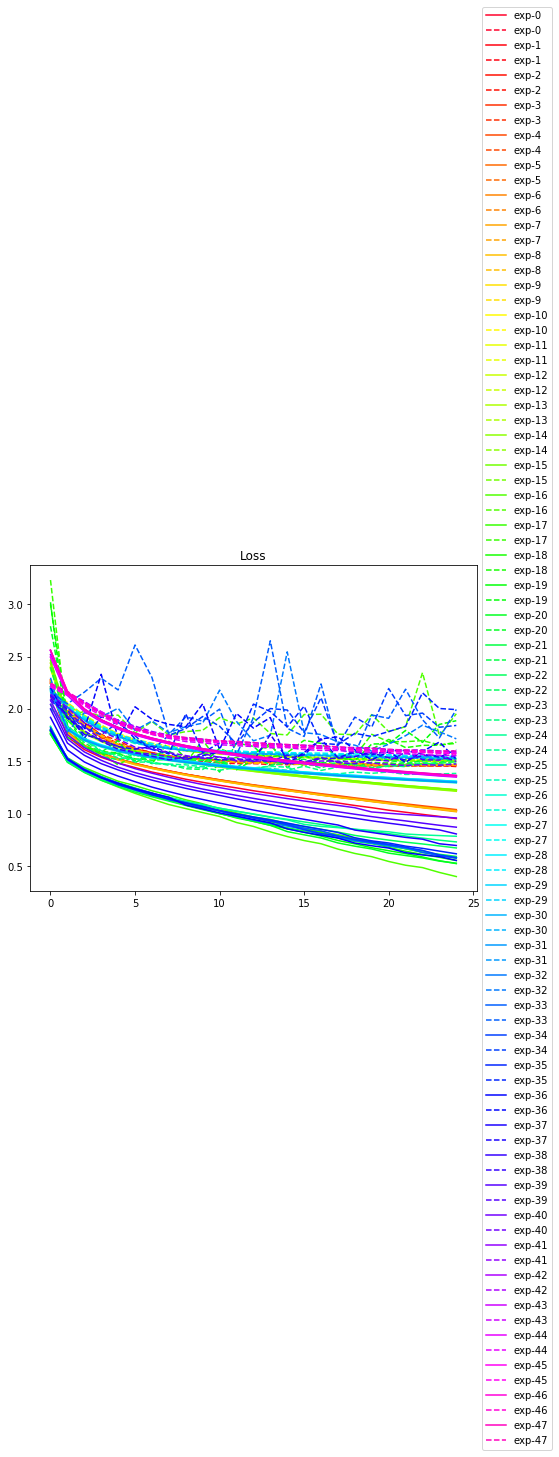

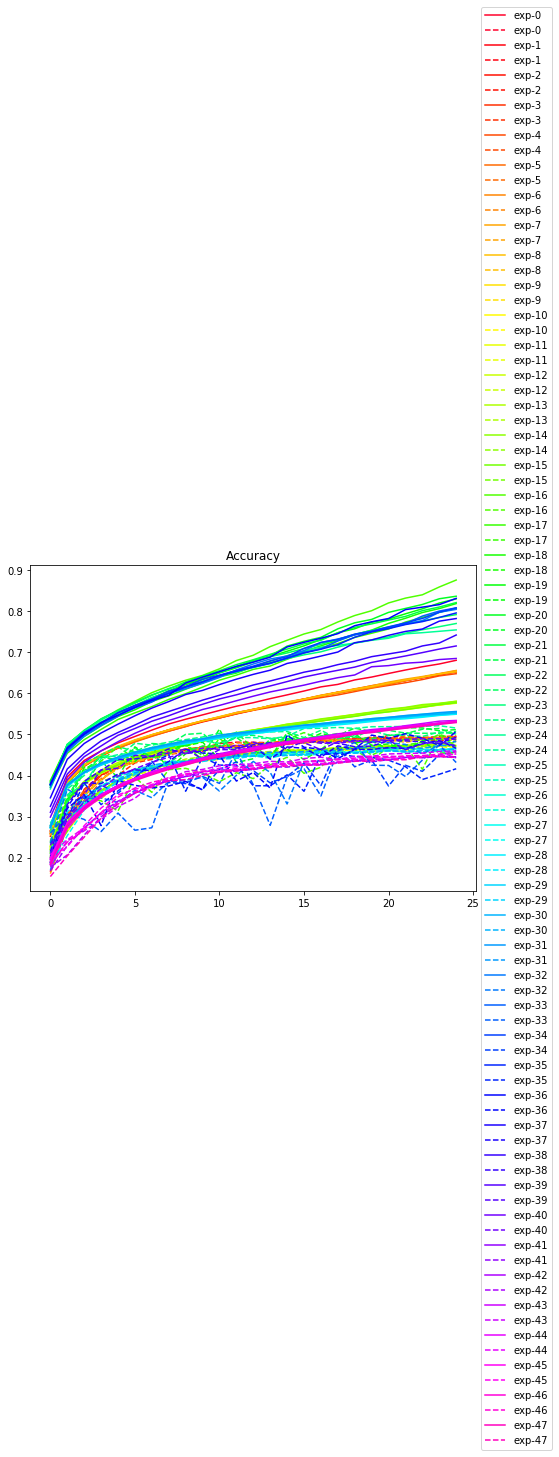

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()